# Applying Deep Learning and Variational Inversion to Quantify and Attribute Climate Change

## Context
### Purpose
The purpose of the notebook is to explore the process and demonstrate the power of using a climate simulation and observation data with a convolutional neural network in the detection of climate change and a variational inversion approach to attribute forcings to changes in global mean surface temperatures from 1900 to 2014. 

### Description
The modelling pipeline consists of the following three procedures: data acquisition & preprocessing, climate change detection and climate change attribution. 
* Observations (OBS) of the 2 m air temperature over the continents from HadCRUT4 (Morice et al., 2012) blended with sea surface temperature from HadISST412 (Rayner et al., 2003). The outputs of ocean-atmosphere general circulation models from the Coupled Model Intercomparison Project 6 (CMIP6) (Eyring et al., 2016) are also acquired and divided into several categories based on used forcings: single-forcing simulations utilizing greenhouse gas concentration (GHG), single-forcing simulations utilizing anthropogenic aerosols (AER), single-forcing simulations utilizing natural forcings such as volcanic aerosols and solar variations (NAT), and historical simulations using all the external forcings (HIST). The data is converted into an annual mean and is spatially averaged over the globe to obtain the global mean surface temperature (GMST). Then the mean temperatures of the pre-industrial time period (1850-1900) are removed from the period of interest (1900-2014) to obtain the temperature anomalies. 
* To determine the relation between the GMST of the single-forcing models GHG, AER, NAT to that of HIST, a convolutional neural network (CNN) is trained. The CNN uses the single-forcing model simulations as input of size (3,115), and uses the HIST simulations as the target of size (1,115). To estimate whether the added non-linearities of the CNN model improve the model performance, a simple linear model is trained using the same inputs and targets. 
* The trained CNN is then used to obtain the variational inversion using the backpropagation algorithm. In this case, OBS time series are used and linked to the single-forcing models (GHG, AER, NAT).         

The model was implemented in Python 3.10 using PyTorch v1.13.0. Further details can be found in the Environmental Data Science paper ["Detection and attribution of climate change: A deep learning and variational approach"](https://doi.org/10.1017/eds.2022.17](https://doi.org/10.1017/eds.2022.17).

### Highlights
* Acquire, pre-process and visualize the observation and climate simulation data.
* Train a CNN model to predict the historical simulation time series (HIST) given the three single-forcing model simulations (GHG, AER, NAT).
* Use the trained CNN model combined with a variational approach to estimate the three forcings given observation (OBS) data.  

### Abbreviations
* OBS - observations
* AER - single forcing simulations utilizing anthropogenic aerosols
* GHG - single forcing simulations utilizing greenhouse gases
* NAT - single forcing simulations utilizing natural forcings
* HIST - historical simulations using all external forcings
* CMIP6 - Coupled Model Intercomparison Project 6
* GMST - Global Mean Surface Temperature
* CNN - Convolutional Neural Network
* MSE - Mean Squared Error

### Contributions

#### Notebook
* Viktor Domazetoski (author), University of Göttingen, [@ViktorDomazetoski](https://github.com/ViktorDomazetoski) [ORCID](https://orcid.org/0000-0001-9830-7032)
* Andrés Zúñiga-González (author), University of Cambridge, [@ancazugo](https://github.com/ancazugo)
* Owen Allemang (author), University of Cambridge, [@SkirOwen](https://github.com/SkirOwen)

#### Modelling codebase
* Constantin Bône (author), UMR LOCEAN, Sorbonne Université, UMR ISIR, Sorbonne Université
* Guillaume Gastineau (author), UMR LOCEAN, Sorbonne Université
* Sylvie Thiria (author), UMR LOCEAN, Sorbonne Université
* Patrick Gallinari (author), UMR ISIR, Sorbonne Université, Criteo AI Lab

#### Modelling publications
Bône, Constantin, Guillaume Gastineau, Sylvie Thiria, and Patrick Gallinari. "Detection and attribution of climate change: A deep learning and variational approach." *Environmental Data Science* 1 (2022): e27.
[https://doi.org/10.1017/eds.2022.17](https://doi.org/10.1017/eds.2022.17)

### Data publications
- Eyring, V., Bony, S., Meehl, G. A., Senior, C. A., Stevens, B., Stouffer, R. J., & Taylor, K. E. (2016). Overview of the Coupled Model Intercomparison Project Phase 6 (CMIP6) experimental design and organization. Geoscientific Model Development, 9(5), 1937-1958.
- Morice, C. P., Kennedy, J. J., Rayner, N. A., & Jones, P. D. (2012). Quantifying uncertainties in global and regional temperature change using an ensemble of observational estimates: The HadCRUT4 data set. Journal of Geophysical Research: Atmospheres, 117(D8).
- Rayner, N. A. A., Parker, D. E., Horton, E. B., Folland, C. K., Alexander, L. V., Rowell, D. P., ... & Kaplan, A. (2003). Global analyses of sea surface temperature, sea ice, and night marine air temperature since the late nineteenth century. Journal of Geophysical Research: Atmospheres, 108(D14).
- Richardson, M., Cowtan, K., & Millar, R. J. (2018). Global temperature definition affects achievement of long-term climate goals. Environmental Research Letters, 13(5), 054004.

### Source code
The notebook contributors acknowledge the authors of the paper for providing a reproducible and public code available at https://gitlab.com/ConstantinBone/detection-and-attribution-of-climate-change-a-deep-learning-and-variational-approach. The source code of the paper was adapted to this notebook.

## Load libraries

In [1]:
'''Math & Data Libraries'''
import os
import numpy as np
import random
import pandas as pd
import netCDF4 as nc4
from scipy import signal
import pooch

''' ML Libraries'''
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import pickle

''' Miscellaneous Libraries'''
from tqdm import tqdm
import warnings

'''Visualization Libraries'''
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid", {"grid.color": "0.5", "axes.edgecolor": "0.2"})
color_palette = ["#FF8853", "#FFE174", "#007597", "#C1C36D", "#00A697", "#BC97E0", "#ffc0bf"]

warnings.filterwarnings(action='ignore')

## Variables

In [2]:
# Dictionary of dictionaries containing the number of simulations per forcing per model
model_dict = {
"IPSL" : {'hist-GHG' : 10,'hist-aer' : 10, 'hist-nat' : 10,'historical' : 32},
"ACCESS" : {'hist-GHG' : 3,'hist-aer' : 3, 'hist-nat' : 3,'historical' : 30},
"CESM2" : {'hist-GHG' : 3,'hist-aer' : 2, 'hist-nat' : 3,'historical' : 11},
"BCC" : {'hist-GHG' : 3,'hist-aer' : 3, 'hist-nat' : 3,'historical' : 3},
"CanESM5" : {'hist-GHG' : 50,'hist-aer' : 30, 'hist-nat' : 50,'historical' : 65},
"FGOALS" : {'hist-GHG' : 3,'hist-aer' : 3, 'hist-nat' : 3,'historical' : 6},
"HadGEM3" : {'hist-GHG' : 4,'hist-aer' : 4, 'hist-nat' : 4,'historical' : 5},
"MIRO" : {'hist-GHG' : 3,'hist-aer' : 3, 'hist-nat' : 3,'historical' : 50},
"ESM2" : {'hist-GHG' : 5,'hist-aer' : 5, 'hist-nat' : 5,'historical' : 7},
"NorESM2" : {'hist-GHG' : 3,'hist-aer' : 3, 'hist-nat' : 3,'historical' : 3},
"CNRM" : {'hist-GHG' : 9,'hist-aer' : 10, 'hist-nat' : 10,'historical' : 30},
"GISS" : {'hist-GHG' : 10,'hist-aer' : 12, 'hist-nat' : 20,'historical' : 19}
}

model_list = ['CanESM5', 'CNRM', 'IPSL', 'ACCESS', 'BCC', 'FGOALS', 'HadGEM3', 'MIRO', 'ESM2','NorESM2','CESM2','GISS']

## Classes
We use `torch.nn` and `torch.utils.data` modules to define linear (baseline) and CNN models, and datasets, respectively. 

In [3]:
class CNN_Model(nn.Module):
    """
    A class for a Convolutional Neural Network. 
    The CNN consists of three convolutional layers, each with a padding of 5 
    and a kernel size of 11 that are non-linearly transformed using a hyperbolic tangent function. 
    ---
    Parameters
    ----------
    size_channel : int
        length of the layer (number of neurons) (defaults to 10)  
    bias: boolean
        whether to add a learnable bias to the input (defaults to True)
    
    Methods
    -------
    forward(X):
        Defines the computation performed at every call.
    """
    def __init__(self, size_channel = 10, bias = True):
        super(CNN_Model, self).__init__()
        self.tanh = nn.Tanh()
        self.conv1 = nn.Conv1d(3, size_channel, kernel_size=11, bias=bias, padding=5) # The input layer has a size of 3 due to the three forcings [ghg, aer, nat]
        self.conv2 = nn.Conv1d(size_channel, size_channel, kernel_size=11, bias=bias, padding=5)
        self.conv3 = nn.Conv1d(size_channel, 1, kernel_size=11, bias=bias, padding=5) # The output layer has a size of 1 as the target [hist]

    def forward(self, x):
        """
        Defines the computation performed at every call.
        The input goes through 2 convolutional and hyperbolic tangent layers before being 
        transformed to float and transformed to a tensor of shape (batch_size, N_years)
        ---
        Parameters
        ----------
            x : torch.tensor of shape (batch_size, N_forcings, N_years), where the batch size defaults to 100, N_forcings equals 3 and represents the three forcings [ghg, aer, nat], and N_years equals 115 and represents the data from 1900-2014.
                input tensor containing the batch of data for the three forcings over the time span of interest.
        
        Returns
        -------
            Output of computation : torch.tensor of shape (batch_size, N_years)
                output tensor that tries to predict the historical simulations using all the external forcings as varying boundary conditions
        """
        x = self.conv1(x)
        x = self.tanh(x)
        x = self.conv2(x)
        x = self.tanh(x)
        x = x.float()
        x = self.conv3(x)[:,0,:]
        return x
    
class Linear_Model(nn.Module):
    """
    A class for a Simple Linear Module used for comparison. 
    ---
    Parameters
    ----------
    bias: boolean
        whether to add a learnable bias to the input (defaults to False)
    
    Methods
    -------
    forward(X):
        Defines the computation performed at every call.
    """
    def __init__(self, bias = False):
        super(Linear_Model, self).__init__()
        self.linear = nn.Linear(3, 1, bias = bias)

    def forward(self, X):
        """
        Defines the computation performed at every call.
        The input goes through a linear layer before being transformed to a tensor of shape [batch_size, N_years]
        ---
        Parameters
        ----------
            x : torch.tensor of size (batch_size, N_forcings, N_years), where the batch size defaults to 100, N_forcings equals 3 and represents the three forcings [ghg, aer, nat], and N_years equals 115 and represents the data from 1900-2014.
                input tensor containing the batch of data for the three forcings over the time span of interest.
        
        Returns
        -------
            Output of computation : torch.tensor of shape (batch_size, N_years)
                output tensor that tries to predict the historical simulations using all the external forcings as varying boundary conditions
        """
        x = self.linear(X.transpose(1,2))
        return x[:,:,0]

class MonDataset(Dataset):
    """
    A pytorch Dataset class that is used as an input for the CNN DataLoader. 
    ---
    Parameters
    ----------
    ghg: list of length 12, with one torch.tensor of shape (N_simu, N_years) for each model. N_simu is dependent on the model and ranges from 3 to 50, and N_years equals 115 and represents the data from 1900-2014  
        A list of tensors, containing the greenhouse gas (GHG) single forcing simulations for each model over the time span of interest.
    aer: list of length 12, with one torch.tensor of shape (N_simu, N_years) for each model. N_simu is dependent on the model and ranges from 3 to 50, and N_years equals 115 and represents the data from 1900-2014  
        A list of tensors, containing the aerosol (AER) single forcing simulations for each model over the time span of interest.
    nat: list of length 12, with one torch.tensor of shape (N_simu, N_years) for each model. N_simu is dependent on the model and ranges from 2 to 30, and N_years equals 115 and represents the data from 1900-2014  
        A list of tensors, containing the natural (NAT) single forcing simulations for each model over the time span of interest.
    historical: list of length 12, with one torch.tensor of shape (N_simu, N_years) for each model. N_simu is dependent on the model and ranges from 3 to 65, and N_years equals 115 and represents the data from 1900-2014  
        A list of tensors, containing the historical (HIST) simulations using all the external forcings as varying boundary conditions for each model over the time span of interest.
    model_of_interest: int
        The index of the model to exclude (include) when creating the train (test) dataset. Set to -1 in order to include all models.
    dataset_type: str, one of ["train", "test"]
        Whether to create a train or test dataset

    Methods
    -------
    len(N_samples):
        Defines the number of samples returned.
    __getitem__():
        Fetch a random data sample.
    """
    def __init__(self, ghg, aer, nat, historical, model_of_interest=-1, dataset_type='train'):
        self.ghg = ghg
        self.aer = aer
        self.nat = nat
        self.historical = historical
        self.dataset_type = dataset_type
        self.model_of_interest = model_of_interest

    def __len__(self, N_samples = 50000):
        """
        Defines the number of samples returned.
        ---
        Parameters
        ----------
            N_samples: int
                Number of samples to return. Defaults to 5e4.
                
        Returns
        -------
            Number of samples : int
        """
        return N_samples

    def __getitem__(self, idx):
        """
        Fetch a random data sample.
        If self.model_of_interest is -1, no models are excluded and in both the train and test sample we randomly choose a model and then randomly choose a simulation for each forcing to add to the dataset.   
        Otherwise, if we want to exclude a specific model, within the train set we randomly choose a model that is not the model we want to exclude, while in the test set we only acquire data from that model. 
        ---
        Returns
        -------
            X : torch.tensor of shape (N_forcings, N_years), where N_forcings equals 3 and represents the three forcings [ghg, aer, nat], and N_years equals 115 and represents the data from 1900-2014.
                a tensor containing a random sample of the simulation data for the three forcings over the time span of interest.
            y : torch.tensor of shape (N_years, ) where N_years equals 115 and represents the data from 1900-2014
                a tensor containing a random sample of the historical simulation data over the time span of interest.
            model_idx : int
                the index of the model used to acquire the random sample
        """
        if(self.dataset_type == 'train'):
            # We sample a random index between 0 and 11 until we find one that is not the model we want to exclude. 
            while True:
                model_idx = random.randint(0, len(self.ghg) - 1)
                if(model_idx != self.model_of_interest): 
                    break

        elif(self.dataset_type == 'test'):
            # We take the index of the model we want to include. 
            model_idx = self.model_of_interest
            # If the model is -1, then all models can potentially be included, thus we randomly sample one of the 12 models
            if(model_idx==-1):
                model_idx = random.randint(0, len(self.ghg) - 1)

        #We sample a simulation of each forcing of the model
        ghg_sample = self.ghg[model_idx][random.randint(0, self.ghg[model_idx].shape[0] - 1)]
        aer_sample = self.aer[model_idx][random.randint(0, self.aer[model_idx].shape[0] - 1)]
        nat_sample = self.nat[model_idx][random.randint(0, self.nat[model_idx].shape[0] - 1)]
        hist_sample = self.historical[model_idx][random.randint(0, self.historical[model_idx].shape[0] - 1)]
        X = torch.stack((ghg_sample, aer_sample, nat_sample)).float()
        y = hist_sample.float()

        return X, y, model_idx

class MonDataset_Inverse(Dataset):
    """
    A pytorch Dataset class that is used as an input for the Inverse model DataLoader. 
    ---
    Parameters
    ----------
    ghg: torch.tensor of shape (N_simu, N_years) for one climate model. N_simu is dependent on the model and ranges from 3 to 50, and N_years equals 115 and represents the data from 1900-2014  
        A tensor, containing the greenhouse gas (GHG) single forcing simulations for one model over the time span of interest.
    aer: ltorch.tensor of shape (N_simu, N_years) for one climate model. N_simu is dependent on the model and ranges from 3 to 50, and N_years equals 115 and represents the data from 1900-2014  
        A tensor, containing the aerosol (AER) single forcing simulations for for one model over the time span of interest.
    nat: torch.tensor of shape (N_simu, N_years) for one climate model. N_simu is dependent on the model and ranges from 2 to 30, and N_years equals 115 and represents the data from 1900-2014  
        A tensor, containing the natural (NAT) single forcing simulations for one model over the time span of interest.

    Methods
    -------
    len(N_samples):
        Defines the number of samples returned.
    __getitem__():
        Fetch a random data sample.
    """
    def __init__(self, ghg, aer, nat):
        self.ghg = ghg
        self.aer = aer
        self.nat = nat

    def __len__(self, N_samples = 100):
        """
        Defines the number of samples returned.
        ---
        Parameters
        ----------
            N_samples: int
                Number of samples to return. Defaults to 5e4.
                
        Returns
        -------
            Number of samples : int
        """
        return N_samples

    def __getitem__(self, idx):
        """
        Fetch a random data sample.
        ---
        Returns
        -------
            X : torch.tensor of shape (N_forcings, N_years), where N_forcings equals 3 and represents the three forcings [ghg, aer, nat], and N_years equals 115 and represents the data from 1900-2014.
                a tensor containing a random sample of the simulation data for the three forcings over the time span of interest.
        """
        
        ghg_sample = self.ghg[random.randint(0, self.ghg.shape[0] - 1)]
        aer_sample = self.aer[random.randint(0, self.aer.shape[0] - 1)]
        nat_sample = self.nat[random.randint(0, self.nat.shape[0] - 1)]
        X = torch.stack((ghg_sample, aer_sample, nat_sample)).float()
        return X

## Functions
We also define some utils functions to load models/simulations, train models and compute spatial calculations.

In [4]:
def calculate_spatial_mean(data):
    """
    Calculate the spatially weighted mean over the globe. 
    ---
    Parameters
    ----------
    data : np.array of shape (N_years, latitude, longitude)
        temporal data covering the entire globe

    Returns
    -------
        obs_data_mean : np.array of shape (N_years)
            Annual spatially averaged observation data from 1900 to 2020.
    """
    data_mean = np.zeros((data.shape[0])) #Initialize np array to keep the results
    latitude = np.linspace(-87.5, 87.5, 36) #Initialize array that contains the mean latitude coordinates of the 5 degree bands used in the spatial weighting
    div = 0 

    for j in range(36): #The latitude dimension of the data is split into 36 parts of 5 degrees which is why we loop throught 36 indices
        for k in range(72): #Similarly, the longitude dimension of the data is split into 72 parts of 5 degrees which is why we loop throught 72 indices
            data_mean += data[:,j,k] * np.cos(np.radians(latitude[j])) 
            div += np.cos(np.radians(latitude[j]))
        data_mean /= div
    return data_mean

def get_observation_data(data_dir):
    """
    Get annual observation (OBS) data of the 2 m air temperature over the continent from HadCRUT4 (Morice et al., 2012) 
    blended with sea surface temperature from HadISST4 (Rayner et al., 2003) over the time span of interest. The data is spatially averaged 
    ---
    Returns
    -------
        obs_data_mean : np.array of shape (121, )
            Annual spatially averaged observation data from 1900 to 2020.
    """
    obs_nc = nc4.Dataset(data_dir + 'obs.nc', 'r')
    obs_temperature_data = obs_nc.variables['temperature_anomaly'][:]
    return calculate_spatial_mean(obs_temperature_data)

def calculate_preindustrial_average(forcing, model_name = 'IPSL', physics = 1):
    """
    Calculate pre-industrial average between years 1850-1900 for a given forcing and model.
    ---
    Parameters
    ----------
    forcing : str: one of ["hist-GHG", "hist-aer", "hist-nat", "historical"]
        type of forcing used in the simulation
    model_name : str: one of the 12 models in the model_list
        model used in the simulation
    physics: int: one of [1, 2]
        parameter used for the GISS model

    Returns
    -------
        preindustrial_average : float
            The pre-industrial average between the years 1850-1900.
    """

    preindustrial_average = np.zeros((36,72))
    # According to authors, for the GISS-E2-1-G, the temperature anomalies were computed separately for the 
    # simulations using two different physics, with different schemes to calculate the aerosols indirect impact
    if(model_name=="GISS"): 
        if(type=='hist-aer'):
            if(physics==1):
                for i in range(model_dict[model_name][forcing]):
                    if(i<5 or i>9):
                        simu_nc = nc4.Dataset(f"{data_dir}{model_name}_{forcing}_{i+1}.nc", 'r')
                        simu_temperature_data = simu_nc.variables['tas'][0:50]
                        preindustrial_average += np.mean(simu_temperature_data, axis=0)/7
            else:  
                for i in range(model_dict[model_name][forcing]):
                    if(i>=5 and i<=9):
                        simu_nc = nc4.Dataset(f"{data_dir}{model_name}_{forcing}_{i+1}.nc", 'r')
                        simu_temperature_data = simu_nc.variables['tas'][0:50]
                        preindustrial_average += np.mean(simu_temperature_data, axis=0)/5
        if(type=='historical'):
            if(physics==1):
                for i in range(model_dict[model_name][forcing]):
                    if(i<10):
                        simu_nc = nc4.Dataset(f"{data_dir}{model_name}_{forcing}_{i+1}.nc", 'r')
                        simu_temperature_data = simu_nc.variables['tas'][0:50]
                        preindustrial_average += np.mean(simu_temperature_data, axis=0)/10
            else:
                for i in range(model_dict[model_name][forcing]):
                    if (i>=10):
                        simu_nc = nc4.Dataset(f"{data_dir}{model_name}_{forcing}_{i+1}.nc", 'r')
                        simu_temperature_data = simu_nc.variables['tas'][0:50]
                        preindustrial_average += np.mean(simu_temperature_data, axis=0)/9
        else:
            for i in range(model_dict[model_name][forcing]):
                if (i>=5 and i<=9):
                    simu_nc = nc4.Dataset(f"{data_dir}{model_name}_{forcing}_{i+1}.nc", 'r')
                    simu_temperature_data = simu_nc.variables['tas'][0:50]
                    preindustrial_average += np.mean(simu_temperature_data, axis=0)/5
    else:
        for i in range(model_dict[model_name][forcing]):
            simu_nc = nc4.Dataset(f"{data_dir}{model_name}_{forcing}_{i+1}.nc", 'r')
            simu_temperature_data = simu_nc.variables['tas'][0:50]
            preindustrial_average += np.mean(simu_temperature_data, axis=0)/model_dict[model_name][forcing]
    return preindustrial_average

def get_simulation(simulation_index, forcing, model_name = 'IPSL', filter = False):
    """
    Get a simulation for a given forcing and model. 
    ---
    Parameters
    ----------
    simulation_index : int
        the index of the requested simulation 
    forcing : str: one of ["hist-GHG", "hist-aer", "hist-nat", "historical"]
        type of forcing used in the simulation
    model_name : str: one of the 12 models in the model_list
        model used in the simulation
    filter : boolean. Defaults to False.
        whether to apply a lowpass filter to the GHG and AER forcings 

    Returns
    -------
        simulation : np.array of shape (N_years), where N_years equals 115
            The data from one simulation for a given forcing and climate model for the years 1900-2014, from which the pre-industrial average is excluded.
    """

    # Calculate pre-industrial average
    physics = 1 
    if(model_name=='GISS'):
        if(forcing=='hist-aer' and (simulation_index>=6 and simulation_index<=10)):
            physics = 2
        elif(forcing=='historical' and simulation_index>10):
            physics = 2
    preindustrial_average = calculate_preindustrial_average(forcing, model_name = model_name, physics = physics)

    # Calculate post-industrial 1900-2015 average
    simu_nc = nc4.Dataset(f"{data_dir}{model_name}_{forcing}_{simulation_index}.nc", 'r')
    simu_temperature_data = simu_nc.variables['tas'][50:]

    # Subtract preindustrial average from the post-industrial data
    simu_temperature_data = simu_temperature_data - preindustrial_average
    simulation = calculate_spatial_mean(simu_temperature_data)
    
    if(filter):
        if(forcing=='hist-GHG' or forcing=='hist-aer'):
            b, a = signal.butter(20, 1/5, btype='lowpass') # Lowpass used in the filtrage of the data
            simulation = signal.filtfilt(b, a, simulation)
    return simulation

def get_all_simulations(forcing, model_name = 'IPSL',filter = False):
    """
    Get all simulations for a given forcing and model. 
    ---
    Parameters
    ----------
    forcing : str: one of ["hist-GHG", "hist-aer", "hist-nat", "historical"]
        type of forcing used in the simulation
    model_name : str: one of the 12 models in the model_list
        model used in the simulation
    filter : boolean. Defaults to False.
        whether to apply a lowpass filter to the GHG and AER forcings 

    Returns
    -------
        simulation_data : np.array of shape (N_simu, N_years), where N_simu is dependent on the model and ranges from 3 to 50, and N_years equals 115 and represents the data from 1900-2014 
            The data from all simulations for a given forcing and climate model for the years 1900-2014, from which the pre-industrial average is excluded.
    """

    simulation_data = np.zeros((model_dict[model_name][forcing], 115))
    for i in range(model_dict[model_name][forcing]):
        simulation_data[i] = get_simulation(i+1, forcing = forcing, model_name = model_name, filter = filter)[0:115]
    return (simulation_data)

def get_model_dataset(model_name = 'ALL', normalize = True, filter = False):
    """
    Get the entire dataset (all simulations for all forcings) for a climate model or all climate models. 
    ---
    Parameters
    ----------
    model_name : str: one of the 12 models in the model_list or "ALL" to acquire dataset for all climate models
        model used in the simulation
    normalize : boolean. Defaults to True.
        whether to normalize all simulations by the maximum historical value 
    filter : boolean. Defaults to False.
        whether to apply a lowpass filter to the GHG and AER forcings 

    Returns
    -------
    ghg: list of length 12, with one torch.tensor of shape (N_simu, N_years) for each model. N_simu is dependent on the model and ranges from 3 to 50, and N_years equals 115 and represents the data from 1900-2014  
        A list of tensors, containing the greenhouse gas (GHG) single forcing simulations for each model over the time span of interest.
    aer: list of length 12, with one torch.tensor of shape (N_simu, N_years) for each model. N_simu is dependent on the model and ranges from 3 to 50, and N_years equals 115 and represents the data from 1900-2014  
        A list of tensors, containing the aerosol (AER) single forcing simulations for each model over the time span of interest.
    nat: list of length 12, with one torch.tensor of shape (N_simu, N_years) for each model. N_simu is dependent on the model and ranges from 2 to 30, and N_years equals 115 and represents the data from 1900-2014  
        A list of tensors, containing the natural (NAT) single forcing simulations for each model over the time span of interest.
    historical: list of length 12, with one torch.tensor of shape (N_simu, N_years) for each model. N_simu is dependent on the model and ranges from 3 to 65, and N_years equals 115 and represents the data from 1900-2014  
        A list of tensors, containing the historical (HIST) simulations using all the external forcings as varying boundary conditions for each model over the time span of interest.
    maximum_historical_list: list of length 1 or length 12, dependent if model_name=="ALL" 
        A list of maximum historical values per model    
    """
    maximum_historical_list = []
    
    if (model_name == 'ALL'):
        aer = []
        ghg = []
        nat = []
        historical = []

        for model_curr in tqdm(model_list):
            print(model_curr)
            aer_curr = torch.tensor(get_all_simulations('hist-aer', model_name = model_curr, filter = filter)[:, 0:115])
            ghg_curr = torch.tensor(get_all_simulations('hist-GHG', model_name = model_curr, filter = filter)[:, 0:115])
            nat_curr = torch.tensor(get_all_simulations('hist-nat', model_name = model_curr, filter = filter)[:, 0:115])
            historical_curr = torch.tensor(get_all_simulations('historical', model_name = model_curr, filter = filter)[:, 0:115])
            historical_max = torch.max(torch.mean(historical_curr, dim=0))
            maximum_historical_list.append(historical_max)

            if(normalize):
                aer_curr = aer_curr / historical_max
                ghg_curr = ghg_curr / historical_max
                nat_curr = nat_curr / historical_max
                historical_curr = historical_curr / historical_max

            aer.append(aer_curr)
            ghg.append(ghg_curr)
            nat.append(nat_curr)
            historical.append(historical_curr)

    else:
        aer = torch.tensor(get_all_simulations('hist-aer', model_name = model_name, filter = filter)[:,0:115])
        ghg = torch.tensor(get_all_simulations('hist-GHG', model_name = model_name, filter = filter)[:,0:115])
        nat = torch.tensor(get_all_simulations('hist-nat', model_name = model_name, filter = filter)[:,0:115])
        historical = torch.tensor(get_all_simulations('historical', model_name = model_name, filter = filter)[:,0:115])
        historical_max = torch.max(torch.mean(historical, dim=0))
        maximum_historical_list.append(historical_max)

        if(normalize):
            aer = aer /historical_max
            ghg = ghg / historical_max
            nat = nat / historical_max
            historical = historical/ historical_max

    return ghg, aer, nat, historical, np.array(maximum_historical_list)
    
def train_models(train_dataloader, test_dataloader, lr = 0.001, N_epoch = 100, size_channel = 10, regularization = 0):
    """
    Train the CNN and Linear model. 
    ---
    Parameters
    ----------
    train_dataloader : pytorch Dataloader
        the data loader for the training set that consists of a sample of simulations from the three forcings for random climate models.
    test_dataloader : pytorch Dataloader
        the data loader for the test set that consists of a sample of simulations from the three forcings for random climate models.
    lr : int
        learning rate. Defaults to 1e-3.
    N_epoch : int
        the number of epochs used to train the model. Defaults to 1e2.
    size_channel : int
        length of the layer (number of neurons) (defaults to 10)  
    regularization : float
        the amount of regularization used when training the model. Defaults to 0, representing no regularization. 

    Returns
    -------
    model_CNN : CNN_Model
        a CNN model which takes data from the three single forcing models [ghg, aer, nat] and is trained to predict the historical (HIST) simulations using all the external forcings as varying boundary conditions
    loss_train_CNN: list of length N_epoch
        list that contains the MSE loss of the model on the training set after each epoch 
    loss_test_CNN: list of length N_epoch
        list that contains the MSE loss of the model on the test set after each epoch 
    model_linear : Linear_Model
        a benchmark linear model which takes data from the three single forcing models [ghg, aer, nat] and is trained to predict the historical (HIST) simulations using all the external forcings as varying boundary conditions
    loss_train_linear: list of length N_epoch
        list that contains the MSE loss of the model on the training set after each epoch 
    loss_test_linear: list of length N_epoch
        list that contains the MSE loss of the model on the test set after each epoch 
    """

    model_CNN = CNN_Model(size_channel = size_channel, bias = True)
    model_linear = Linear_Model(bias = False)

    criterion_CNN = nn.MSELoss()
    criterion_linear = nn.MSELoss()

    optim_CNN = torch.optim.Adam(model_CNN.parameters(), lr=lr, weight_decay = regularization)
    optim_linear = torch.optim.Adam(model_linear.parameters(), lr=lr, weight_decay=regularization)

    loss_train_CNN = []
    loss_test_CNN = []

    loss_train_linear = []
    loss_test_linear = []

    for iter in tqdm(range(N_epoch)):
        loss_total_train_CNN = 0
        loss_total_test_CNN = 0
        length_train_CNN = 0
        length_test_CNN = 0

        loss_total_train_linear = 0
        loss_total_test_linear = 0
        length_train_linear = 0
        length_test_linear = 0

        with torch.no_grad():
            for(X_test, y_test, model_idx) in test_dataloader:
                y_hat_test_CNN = model_CNN(X_test)
                loss_test = criterion_CNN(y_hat_test_CNN.float(), y_test.float())
                loss_total_test_CNN += loss_test
                length_test_CNN += 1

                y_hat_test_linear = model_linear(X_test)
                loss_test = criterion_linear(y_hat_test_linear.float(),y_test.float())
                loss_total_test_linear += loss_test
                length_test_linear += 1

        for(X_train, y_train, model_idx) in train_dataloader:
            y_hat_train_CNN = model_CNN(X_train)
            loss = criterion_CNN(y_hat_train_CNN.float(), y_train.float())
            loss.backward()
            optim_CNN.step()
            loss_total_train_CNN += loss
            optim_CNN.zero_grad()
            length_train_CNN +=1

            y_hat_train_linear = model_linear(X_train)
            loss = criterion_linear(y_hat_train_linear.float(), y_train.float())
            loss.backward()
            optim_linear.step()
            loss_total_train_linear += loss
            optim_linear.zero_grad()
            length_train_linear += 1

        loss_total_train_CNN = loss_total_train_CNN.item() / length_train_CNN
        loss_total_test_CNN = loss_total_test_CNN.item() / length_test_CNN
        loss_total_train_linear = loss_total_train_linear.item() / length_train_linear
        loss_total_test_linear = loss_total_test_linear.item() / length_test_linear

        if(iter%10 == 0):
            print(f"Iteration {iter}:")
            print(f"\tCNN: training loss: {loss_total_train_CNN:.6f}, test loss {loss_total_test_CNN:.6f}")
            print(f"\tLinear: training loss: {loss_total_train_linear:.6f}, test loss {loss_total_test_linear:.6f}")

        loss_train_CNN.append(loss_total_train_CNN)
        loss_test_CNN.append(loss_total_test_CNN)

        loss_train_linear.append(loss_total_train_linear)
        loss_test_linear.append(loss_total_test_linear)

    return model_CNN, np.array(loss_train_CNN), np.array(loss_test_CNN), model_linear, np.array(loss_train_linear), np.array(loss_test_linear)

def train_inverse_model(inputs, target, model, max_iter = 100000, alpha = 0.005):
    """
    Perform backpropagation of the CNN model to obtain the variational inverse model estimates. 
    ---
    Parameters
    ----------
    inputs : torch.tensor() of shape (3,115)
        a tensor that consists of a sample of simulations from the three forcings for random climate models.
    target : torch.tensor() of shape (1,115)
        a tensor that consists of the observation data
    model : CNN_Model()
        the convolutional model trained to predict HIST given [ghg, aer, nat] as input
    max_iter : int
        the maximum number of iterations used in the model. Defaults to 1e5.
    alpha : float
        the loss threshold to perform early model stopping. Defaults to 0.005.

    Returns
    -------
    X : torch.tensor()
        The input that corresponds to the OBS data as determined by the inverse model 
    output_estimate: torch.tensor()
        The model prediction for the determined input 
    """
    X = Variable(inputs.clone().detach(), requires_grad=True)
    optimizer = torch.optim.Adam([X], lr=0.0001)
    criterion = nn.MSELoss()

    for iter in range(max_iter):
        output_estimate = model(X) 
        MSE_loss = criterion(output_estimate.float(), target.float())
        penalization_term_loss = criterion(X.float(), inputs.float())
        loss = MSE_loss + 0.01 * penalization_term_loss

        if(iter%10000 == 0):
            print(f"Iteration {iter}:")
            print(f"\tInverse model: MSE(OBS, CNN(X)): {MSE_loss:.6f}, MSE(X, inputs) {penalization_term_loss:.6f}")

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if(MSE_loss<alpha):
            print(f"Model achieved loss threshold at iteration {iter}:")
            break

    return X, output_estimate

def get_inverse_model_estimates(observation_data, model, normalize = True, denormalize = True, filter = False):
    """
    Train the CNN and Linear model. 
    ---
    Parameters
    ----------
    observation_data : torch.tensor
        a tensor that consists of the observation data
    model : CNN_Model
        the convolutional model trained to predict HIST given [ghg, aer, nat] as input
    normalize : boolean. Defaults to True.
        whether to normalize all simulations by the maximum historical value 
    denormalize : boolean. Defaults to True.
        whether to denormalize all simulations by multiplying by the maximum historical value 
    filter : boolean. Defaults to False.
        whether to apply a lowpass filter to the GHG and AER forcings 

    Returns
    -------
    results_list_input: np.array of shape (N_models, N_forcings, N_years), where N_models = 12, N_forcings = 3, N_years = 115
        array that contains the inverse model input estimates of the [ghg, aer, nat] by backpropagating using the observation data
    results_list_output: np.array of shape (N_models, 1, N_years), where N_models = 12, N_years = 115
        array that contains the inverse model output estimates
    """
    
    results_list_input = []
    results_list_output = []

    for i in tqdm(range(len(model_list))):
        ghg, aer, nat, historical, maximum_historical_list = get_model_dataset(model_name = model_list[i], normalize = True, filter = filter)

        dataloader_inverse_model = DataLoader(MonDataset_Inverse(ghg, aer, nat), batch_size = 1)

        for inputs in dataloader_inverse_model:
            X, output_estimate = train_inverse_model(inputs, observation_data, model, max_iter = 100000)

            X = X.clone().detach().numpy()
            output_estimate = output_estimate.clone().detach().numpy()

            if denormalize:
                X *= maximum_historical_list[-1]
                output_estimate *= maximum_historical_list[-1]

            results_list_input.append(X)
            results_list_output.append(output_estimate)

    results_list_input = np.array(results_list_input)[:, 0]
    results_list_output = np.array(results_list_output)[:, 0]

    with open('./Results/Inverse_Results.npy', 'wb') as f1:
        np.save(f1, results_list_input)
        
    return results_list_input, results_list_output

# Pipeline

## Fetch data

The data can be found in a compressed file data_pre_ind_2 at https://gitlab.com/ConstantinBone/detection-and-attribution-of-climate-change-a-deep-learning-and-variational-approach. We use `pooch` to fetch and unzip them directly from the GitLab repository.

In [5]:
pooch.retrieve(
    url="https://gitlab.com/ConstantinBone/detection-and-attribution-of-climate-change-a-deep-learning-and-variational-approach/-/raw/main/data_pre_ind_2.zip",
    known_hash=None,
    processor=pooch.Unzip(extract_dir='data'),
    path=f".",
    progressbar=True,
)

['/Users/acoca/repos/envdsbook/gallery/93463cac-471a-469d-ad52-0514fd9b67f2/data/data_pre_ind_2/GISS_historical_16.nc',
 '/Users/acoca/repos/envdsbook/gallery/93463cac-471a-469d-ad52-0514fd9b67f2/data/data_pre_ind_2/GISS_hist-aer_9.nc',
 '/Users/acoca/repos/envdsbook/gallery/93463cac-471a-469d-ad52-0514fd9b67f2/data/data_pre_ind_2/CanESM5_historical_58.nc',
 '/Users/acoca/repos/envdsbook/gallery/93463cac-471a-469d-ad52-0514fd9b67f2/data/data_pre_ind_2/CNRM_historical_1.nc',
 '/Users/acoca/repos/envdsbook/gallery/93463cac-471a-469d-ad52-0514fd9b67f2/data/data_pre_ind_2/HadGEM3_hist-GHG_4.nc',
 '/Users/acoca/repos/envdsbook/gallery/93463cac-471a-469d-ad52-0514fd9b67f2/data/data_pre_ind_2/IPSL_hist-GHG_3.nc',
 '/Users/acoca/repos/envdsbook/gallery/93463cac-471a-469d-ad52-0514fd9b67f2/data/data_pre_ind_2/obs.nc',
 '/Users/acoca/repos/envdsbook/gallery/93463cac-471a-469d-ad52-0514fd9b67f2/data/data_pre_ind_2/NorESM2_hist-aer_3.nc',
 '/Users/acoca/repos/envdsbook/gallery/93463cac-471a-469d-a

## Load data

We first start by acquiring the annual OBS data of the 2 m air temperature over the continents from HadCRUT4 blended with sea surface temperature from HadISST4. The data is spatially averaged over the globe and only the time span of interest (1900 - 2014) is acquired. To make OBS and HIST comparable, OBS is corrected of its blending effects using a 1.06 multiplier coefficient (Richardson et al., 2018). Finally, the OBS data is normalized to a maximum of 1 by dividing the series with the OBS maximum.

We then get the simulation data for all forcings (GHG, AER, NAT, HIST) of all 12 climate models. The simulation data is spatially averaged over the globe to create an annual mean from which the pre-industrial average is subtracted. The simulations are then also max-normalized by dividing with the historical maximum. 

In [7]:
# Set input data dir
data_dir = 'data/data_pre_ind_2/'

# Get observation data
observation_data = torch.tensor(get_observation_data(data_dir))[0:115] * 1.06
observation_max = torch.max(observation_data)
observation_data = observation_data /observation_max

# Get the simulation data for all forcings and all climate models
ghg, aer, nat, historical, maximum_historical_list = get_model_dataset(model_name = 'ALL', normalize = True, filter = False)

  0%|                                                                                                                                                | 0/12 [00:00<?, ?it/s]

CanESM5


  8%|███████████▎                                                                                                                           | 1/12 [01:42<18:45, 102.33s/it]

CNRM


 17%|██████████████████████▋                                                                                                                 | 2/12 [01:56<08:25, 50.51s/it]

IPSL


 25%|██████████████████████████████████                                                                                                      | 3/12 [02:12<05:11, 34.56s/it]

ACCESS


 33%|█████████████████████████████████████████████▎                                                                                          | 4/12 [02:23<03:22, 25.30s/it]

BCC


 42%|████████████████████████████████████████████████████████▋                                                                               | 5/12 [02:24<01:57, 16.74s/it]

FGOALS


 50%|████████████████████████████████████████████████████████████████████                                                                    | 6/12 [02:26<01:10, 11.67s/it]

HadGEM3


 58%|███████████████████████████████████████████████████████████████████████████████▎                                                        | 7/12 [02:29<00:43,  8.68s/it]

MIRO


 67%|██████████████████████████████████████████████████████████████████████████████████████████▋                                             | 8/12 [02:59<01:01, 15.47s/it]

ESM2


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 9/12 [03:02<00:34, 11.61s/it]

NorESM2


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 10/12 [03:03<00:16,  8.46s/it]

CESM2


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 11/12 [03:06<00:06,  6.68s/it]

GISS


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [03:13<00:00, 16.10s/it]


In [8]:
N_simu_table_list = []
for i in range(len(model_list)):
    N_simu_table_list.append([model_list[i], ghg[i].shape[0], aer[i].shape[0], nat[i].shape[0], historical[i].shape[0]])
N_simu_table = pd.DataFrame(N_simu_table_list, columns = ["Model Name", "#GHG", "#AER", "#NAT", "#HIST"])

The following table shows the number of simulations per forcing per climate model (Table 1. of the paper). It should be noted that the paper lists a value of 50 AER simulations and 30 NAT simulations for the CanESM5 model, while the data show the opposite, thus the mistake is probably due to a manual labeling error. 

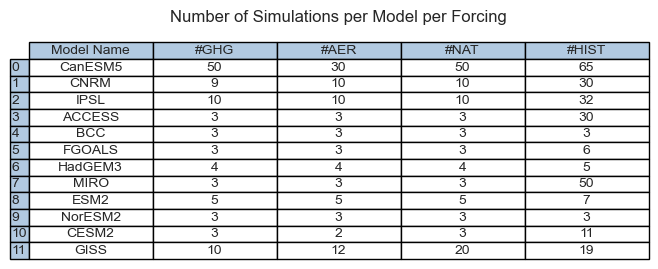

In [9]:
fig = plt.figure(figsize = (8, .16))

rcolors = plt.cm.BuPu(np.full(len(N_simu_table.index), 0.3))
ccolors = plt.cm.BuPu(np.full(len(N_simu_table.columns), 0.3))

plt.table(cellText = N_simu_table.values, rowLabels = N_simu_table.index, 
          colLabels = N_simu_table.columns, cellLoc='center',                      
          rowColours = rcolors, colColours = ccolors)

#add title to table
plt.title('Number of Simulations per Model per Forcing')
#turn axes off
plt.axis('off')
plt.show()

To visualize the intra-specific and inter-specific variation of the simulations for the 12 climate models, we plot the three single-forcing simulations: GHG (orange), AER (yellow), NAT (blue) and the historical simulation using all external forcings: HIST (olive) for each model. The mean value of the simulations per forcing are shown with a solid line, while the shaded color represents one standard deviation off the mean. The observation data: OBS is also shown with a black dotted line.

In [ ]:
fig, ax = plt.subplots(figsize = (16,10), ncols = 4, nrows = 3)
plt.suptitle("Visualization of the simulations of the 12 models", fontsize = 20)
for i in range(len(model_list)):
    plt.subplot(3, 4, i+1)
    plt.title(model_list[i])
    for j, (forcing, forcing_name) in enumerate(zip([ghg, aer, nat, historical], ["GHG", "AER", "NAT", "HIST"])):
        forcing_mean = torch.mean(forcing[i], axis=0)
        forcing_std = torch.std(forcing[i], axis=0)

        plt.plot(forcing_mean, color = color_palette[j], linewidth = 3, alpha = 0.8, label = forcing_name)
        plt.fill_between(np.arange(115), forcing_mean - forcing_std, forcing_mean + forcing_std, color = color_palette[j], alpha = 0.3)
    plt.plot(observation_data, color = "#444444", linestyle = ":", linewidth = 3, alpha = 1, label = "OBS")

    plt.ylim(-2.5, 2.5)
    plt.xticks(np.linspace(0, 120, 5), [str(tick+1900) for tick in np.linspace(0, 120, 5, dtype=int)])
    plt.yticks(np.linspace(-2.5, 2.5, 5), [str(np.round(tick, 2)) for tick in np.linspace(-2.5, 2.5, 5, dtype=float)])

    if(i==0):
        handles, labels = ax[0,0].get_legend_handles_labels()
        plt.legend(handles, ["GHG", "AER", "NAT", "HIST", "OBS"], loc = "upper left", fontsize = 10)
    if(i%4==0):
        plt.ylabel(f"GMST (\N{DEGREE SIGN}C)", fontsize = 13)
    if(i>7):
        plt.xlabel(f"Years", fontsize = 13)
plt.tight_layout()
plt.show()


The following figure shows the variation of the forcings across all 12 climate models. The same color code as the previous figure is used.

In [ ]:
fig, ax = plt.subplots(figsize = (8,5), ncols = 1, nrows = 1)
plt.suptitle("Mean and standard deviation of the simulations of the 12 models", fontsize = 20)
for j, (forcing, forcing_name) in enumerate(zip([ghg, aer, nat, historical], ["GHG", "AER", "NAT", "HIST"])):
    forcing_mean = torch.mean(torch.cat(forcing), axis=0)
    forcing_std = torch.std(torch.cat(forcing), axis=0)
        
    plt.plot(forcing_mean, color = color_palette[j], linewidth = 3, alpha = 0.8, label = forcing_name)
    plt.fill_between(np.arange(115), forcing_mean - forcing_std, forcing_mean + forcing_std, color = color_palette[j], alpha = 0.3)

plt.plot(observation_data, color = "#444444", linestyle = ":", linewidth = 3, alpha = 1, label = "OBS")

plt.ylim(-2.5, 2.5)
plt.xticks(np.linspace(0, 120, 5), [str(tick+1900) for tick in np.linspace(0, 120, 5, dtype=int)])
plt.yticks(np.linspace(-2.5, 2.5, 5), [str(np.round(tick, 2)) for tick in np.linspace(-2.5, 2.5, 5, dtype=float)])

plt.ylabel(f"GMST (\N{DEGREE SIGN}C)", fontsize = 13)
plt.xlabel(f"Years", fontsize = 13)

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, ["GHG", "AER", "NAT", "HIST", "OBS"], loc = "upper left", fontsize = 10)

plt.tight_layout()
plt.show()

## CNN
### Model training
To train the model for the detection of climate change given the single-forcing simulations, we first define a custom dataloader. The data loader works such that it randomly picks a model and a simulation index to create a data sample of input (GHG, AER, NAT) and a target (HIST).

```python
BATCH_SIZE = 100
train_dataloader = DataLoader(MonDataset(ghg, aer, nat, historical, model_of_interest = -1, dataset_type = 'train'), shuffle=True, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(MonDataset(ghg, aer, nat, historical, model_of_interest = -1, dataset_type = 'test'), shuffle=True, batch_size=BATCH_SIZE)
```

The train and test dataloaders are then used as input to a convolutional network with three convolutional layers and a hyperbolic tangent activation function. As a result of the function, we receive the trained CNN model, as well as a linear model which is used for comparison. 

```python
model_CNN, loss_train_CNN, loss_test_CNN, model_linear, loss_train_linear, loss_test_linear = train_models(train_dataloader, test_dataloader, N_epoch = 100)

## Save models
pickle.dump(model_CNN, open('Models/CNN_model.pkl', 'wb'))
pickle.dump(model_linear, open('Models/Linear_model.pkl', 'wb'))
```

### Model performance

In [15]:
from src.model import Linear_Model, CNN_Model
import pickle

In [5]:
lm = model.Linear_Model()

In [16]:
## Load models
model_linear = pickle.load(open('outputs/models/Linear_model.pkl', 'rb'))
model_CNN = pickle.load(open('outputs/models/CNN_model.pkl', 'rb'))

In [13]:
with open('outputs/models/Linear_model.pkl', 'rb') as f:
    model_linear = pickle.load(f)

In [ ]:
skip_first_epochs = 5

fig, ax = plt.subplots(figsize = (8,5), ncols = 1, nrows = 1)
plt.suptitle("Loss per Epoch of the CNN and Linear models", fontsize = 20)

for i, (loss_list, dataset_type) in enumerate(zip([loss_train_CNN, loss_test_CNN], ["Train", "Test"])):
    plt.plot(loss_list[skip_first_epochs:], color = color_palette[i+1], linestyle = "-", linewidth = 3, alpha = 0.8, label = f"CNN Model {dataset_type} Loss")

for i, (loss_list, dataset_type) in enumerate(zip([loss_train_linear, loss_test_linear], ["Train", "Test"])):
    plt.plot(loss_list[skip_first_epochs:], color = color_palette[i+1], linestyle = "--", linewidth = 3, alpha = 0.8, label = f"Linear Model {dataset_type} Loss")

plt.xlabel("# Epochs")
plt.ylabel("MSE Loss")
plt.yscale("log")
plt.legend(loc = "upper right", fontsize = 10)

plt.tight_layout()
plt.show()

# Inverse model

Finally, we use trained CNN model to estimate the contribution of each forcing in the multi-model dataset using variational inversion. This is done by using the OBS data as the target variable of the CNN model and backpropagating until we get estimates of the input.

```python
results_list_input, results_list_output = get_inverse_model_estimates(observation_data, model_CNN, normalize = True, denormalize = False)
```

In [ ]:
# Load inverse model results
results_list_input = np.load('./outputs/results/Inverse_Results.npy')

Now we visualize the variational inverse model estimates for each model compared to the climate model simulations. We plot the three single-forcing simulations: GHG (orange), AER (yellow), NAT (blue) for the inverse estimates (dashed line) and the original climate model simulations (solid line). The color shades show one standard deviation across the inversion (dashed area) and the simulations. The observation data: OBS is also shown with a black dotted line.

In [ ]:
fig, ax = plt.subplots(figsize = (16,10), ncols = 4, nrows = 3)
plt.suptitle("Mean and standard deviation of the inverse model estimates of the simulations", fontsize = 20)
for i in range(len(model_list)):
    plt.subplot(3, 4, i+1)
    plt.title(model_list[i])
    for j, (forcing, forcing_name) in enumerate(zip([ghg, aer, nat], ["GHG", "AER", "NAT"])):
        forcing_mean = torch.mean(forcing[j], axis=0)
        forcing_std = torch.std(forcing[j], axis=0)

        forcing_mean_inverse = np.mean(results_list_input[100*i:100*(i+1)], axis=0)[j]
        forcing_std_inverse = np.std(results_list_input[100*i:100*(i+1)], axis=0)[j]
        
        plt.plot(forcing_mean, color = color_palette[j], linestyle = "-", linewidth = 3, alpha = 0.8, label = forcing_name)
        plt.fill_between(np.arange(115), forcing_mean - forcing_std, forcing_mean + forcing_std, color = color_palette[j], alpha = 0.3)

        plt.plot(forcing_mean_inverse, color = color_palette[j], linestyle = "--", linewidth = 3, alpha = 0.8, label = forcing_name)
        plt.fill_between(np.arange(115), forcing_mean_inverse - forcing_std_inverse, forcing_mean_inverse + forcing_std_inverse, hatch='////', color = "black", facecolor = color_palette[j], alpha = 0.3)
        
    plt.plot(observation_data, color = "#444444", linestyle = ":", linewidth = 3, alpha = 1, label = "OBS")

    plt.ylim(-2.5, 2.5)
    plt.xticks(np.linspace(0, 120, 5), [str(tick+1900) for tick in np.linspace(0, 120, 5, dtype=int)])
    plt.yticks(np.linspace(-2.5, 2.5, 5), [str(np.round(tick, 2)) for tick in np.linspace(-2.5, 2.5, 5, dtype=float)])

    if(i==0):
        handles, labels = ax[0,0].get_legend_handles_labels()
        plt.legend(handles, ["GHG", "AER", "NAT", "HIST", "OBS"], loc = "upper left", fontsize = 10)
    if(i%4==0):
        plt.ylabel(f"GMST (\N{DEGREE SIGN}C)", fontsize = 13)
    if(i>7):
        plt.xlabel(f"Years", fontsize = 13)
        
plt.tight_layout()
plt.show()

The following figure visualizes the same figure by taking all models into account. The same color as the previous figure is used.

In [ ]:
fig, ax = plt.subplots(figsize = (8,5), ncols = 1, nrows = 1)
plt.suptitle("Mean and standard deviation of the inverse model estimates of the simulations", fontsize = 20)
for i, (forcing, forcing_name)  in enumerate(zip([ghg, aer, nat], ["GHG", "AER", "NAT"])):
    forcing_std = torch.std(torch.cat(forcing), axis=0)
    forcing_mean = torch.mean(torch.cat(forcing), axis=0)

    forcing_mean_inverse = np.mean(results_list_input, axis=0)[i]
    forcing_std_inverse = np.std(results_list_input, axis=0)[i]

    plt.plot(forcing_mean, color = color_palette[i], linestyle = "-", linewidth = 3, alpha = 0.8, label = forcing_name)
    plt.fill_between(np.arange(115), forcing_mean - forcing_std, forcing_mean + forcing_std, color = color_palette[i], alpha = 0.3)

    plt.plot(forcing_mean_inverse, color = color_palette[i], linestyle = "--", linewidth = 3, alpha = 0.8, label = forcing_name)
    plt.fill_between(np.arange(115), forcing_mean_inverse - forcing_std_inverse, forcing_mean_inverse + forcing_std_inverse, hatch='////', color = "black", facecolor = color_palette[i], alpha = 0.3)

plt.plot(observation_data, color = "#444444", linestyle = ":", linewidth = 3, alpha = 1, label = "OBS")

plt.ylim(-2.5, 2.5)
plt.xticks(np.linspace(0, 120, 5), [str(tick+1900) for tick in np.linspace(0, 120, 5, dtype=int)])
plt.yticks(np.linspace(-2.5, 2.5, 5), [str(np.round(tick, 2)) for tick in np.linspace(-2.5, 2.5, 5, dtype=float)])
plt.xlabel(f"Years", fontsize = 13)
plt.ylabel(f"GMST (\N{DEGREE SIGN}C)", fontsize = 13)

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, ["GHG", "Inversion of GHG", "AER", "Inversion of AER", "NAT", "Inversion of NAT", "OBS"], loc = "upper left", fontsize = 10)
plt.tight_layout()
plt.show()

Finally, we visualize the mean and standard deviation of the variational inverse model estimates over time, and further show the results for two years, in this case 1993 and 2014 for greenhouse gases (orange), anthropogenic aerosols (yellow) and natural forcings (blue). 

In [ ]:
fig, ax = plt.subplots(figsize = (12.4, 4.8), ncols = 3, nrows = 1, gridspec_kw = {'width_ratios' : [3,1,1]})
plt.suptitle("Mean and standard deviation of the inverse model estimates of the simulations", fontsize = 20)
plt.subplot(1,3,1)
for i, (forcing, forcing_name)  in enumerate(zip([ghg, aer, nat], ["GHG", "AER", "NAT"])):
    forcing_mean_inverse = np.mean(results_list_input, axis=0)[i]
    forcing_std_inverse = np.std(results_list_input, axis=0)[i]

    plt.plot(forcing_mean_inverse, color = color_palette[i], linestyle = "--", linewidth = 3, alpha = 0.8, label = forcing_name)
    plt.fill_between(np.arange(115), forcing_mean_inverse - forcing_std_inverse, forcing_mean_inverse + forcing_std_inverse, color = color_palette[i], alpha = 0.3)

plt.plot(observation_data, color = "#444444", linestyle = ":", linewidth = 3, alpha = 1, label = "OBS")

plt.ylim(-2.5, 2.5)
plt.xticks(np.linspace(0, 120, 5), [str(tick+1900) for tick in np.linspace(0, 120, 5, dtype=int)])
plt.yticks(np.linspace(-2.5, 2.5, 5), [str(np.round(tick, 2)) for tick in np.linspace(-2.5, 2.5, 5, dtype=float)])
plt.xlabel(f"Years", fontsize = 13)
plt.ylabel(f"GMST (\N{DEGREE SIGN}C)", fontsize = 13)

handles, labels = ax[0].get_legend_handles_labels()
plt.legend(handles, ["Inversion of GHG", "Inversion of AER", "Inversion of NAT", "OBS"], loc = "upper left", fontsize = 10)

for j, year in enumerate([1993, 2014]):
    plt.subplot(1,3,j+2)
    year_ind = year - 1900
    for i, forcing_name  in enumerate(["GHG", "AER", "NAT"]):
        result_forcing_year = results_list_input[:, i, year_ind] 
        # bin = int(round((np.max(result_forcing_year) - np.min(result_forcing_year)) * 10)) +1
        plt.hist(results_list_input[:, i, year_ind], bins = np.linspace(-2.5, 2.5, 30), alpha = 0.5, color = color_palette[i], orientation = "horizontal")
        
        plt.ylim(-2.5, 2.5)
        plt.title(year)
        plt.xlabel(f"Frequency", fontsize = 13)
        plt.ylabel(f"GMST (\N{DEGREE SIGN}C)", fontsize = 13)

plt.tight_layout()
plt.show()

As we can see in the left panel of the image, the results are comparable to the original simulations, however, with a slightly increased standard deviation. The right panel illustrates the distribution of the results from the inversions in 1993 and 2014, showing a clear delineation between the effect of GHG compared to AER and NAT forcings. Furthermore, this results obtained in this run of the notebook slighly differ from the ones in the original paper. This could be due to multiple reasons, such as the stochasticity involved in training the models or slight differences in the pipeline compared to the original paper.  


### Limitations
- Data Uncertainty: The analysis relies on the the accuracy and quality of the data which is used to train the models. However, especially when using the climate simulation data (GHG, AER, NAT, HIST), we rely on the use of climate models which inherently carry uncertainties due to simplified representations of complex climate processes, thus can bias the changes to specific forcings. 
- Spatiotemporal Resolution: The analysis provides GMST attribution on a global scale, but it may not capture regional variations adequately. Regional climate responses and localized forcings might not be fully accounted for, limiting the ability to attribute changes at finer spatial scales. However, this is something the authors of the paper discuss they will research in future work.
- Incomplete Forcings: The analysis focuses on attributing GMST changes to well-mixed greenhouse gases, anthropogenic aerosols, and natural forcings. However, other external factors, such as land-use changes or solar variability, may also contribute to GMST variations and are not explicitly considered in this analysis.
- Future Projection Uncertainty: The analysis focuses on historical data up to 2014, and the attribution results may not fully reflect potential changes beyond that period. Projecting the attribution results into the future introduces additional uncertainties related to emission scenarios and climate model projections.
- Sensitivity to Methodology: The results of the analysis may be sensitive to the specific methodology chosen, including the design of the variational inversion approach and the choice of climate models used. Alternative methodologies could yield different attribution outcomes.

## Summary
- The climate change attribution problem is a very important issue that pertains to understanding the exact causes behind climate change. However, most approaches tackling this problem have relied on the classical forcing additivity assumption which precludes any non-linear combinations that are ubiquitous in nature.
- In this notebook, we utilize a CNN architecture to escape this constraint and estimate the historical global mean surface temperature using single forcing simulations (greenhouse gases, anthropogenic aerosols and natural forcings) from ocean-atmosphere general circulation models from the Coupled Model Intercomparison Project 6 (CMIP6). 
- The results show that the CNN performs better and obtains a lower mean square error compared to a simpler linear model trained on the same data. 
- The trained CNN is then used with a variational inversion approach to estimate the single forcings when given observation data from HadCRUT4 and HAdISST412. The estimated inversions of the single forcings show high similarity to the original data and provides coherent results with larger confidence intervals.          


## Additional information
**Dataset**: Bône, Constantin. (2023).  Detection and attribution of climate change a Deep Learning and Variational approach. https://gitlab.com/ConstantinBone/detection-and-attribution-of-climate-change-a-deep-learning-and-variational-approach/-/blob/main/data_pre_ind_2.zip - Commit 8dff0335be7dbf07e56c7a99bef6b12453360012

**License**: The code in this notebook is licensed under the MIT License. The Environmental Data Science book is licensed under the Creative Commons by Attribution 4.0 license. See further details [here](https://github.com/alan-turing-institute/environmental-ds-book/blob/master/LICENSE.md).

**Contact**: If you have any suggestion or report an issue with this notebook, feel free to [create an issue](https://github.com/alan-turing-institute/environmental-ds-book/issues/new/choose) or or send a direct message to environmental.ds.book@gmail.com.

In [ ]:
from datetime import date
print(f'Last tested: {date.today()}')